In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import os
import random
import matplotlib.pyplot as plt

# Importing our models and utils
from models.x16x16_to_32x32.HVAE import HierarchicalVDVAE
from utils.utils import gaussian_kl, PerceptualLoss
from utils.datasets import CIFAR_SR

c:\UniProgramme\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\UniProgramme\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\UniProgramme\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
cuda = True
device = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
print(device)

scale_factor = 2
image_size = 32
num_channels = 3
latent_dims = [64, 128, 256]

batch_size = 64
num_epochs = 15
save_interval = num_epochs
validation_interval = 5

train_dataset = CIFAR_SR(scale_factor=2, split="train", download=True, device=device)
val_dataset = CIFAR_SR(scale_factor=2, split="test", download=True, device=device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset Loaded: {len(train_dataset)} training samples, {len(val_dataset)} validation samples")

cuda
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Dataset Loaded: 50000 training samples, 10000 validation samples


In [3]:
vdvae = HierarchicalVDVAE()
print(vdvae)


HierarchicalVDVAE(
  (encoder): HierarchicalEncoder(
    (in_conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (down1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (down2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu1): Linear(in_features=8192, out_features=64, bias=True)
    (fc_logvar1): Linear(in_features=8192, out_features=64, bias=True)
    (fc_mu2): Linear(in_features=16384, out_features=128, bias=True)
    (fc_logvar2): Linear(in_features=16384, out_features=128, bias=True)
    (fc_mu3): Linear(in_features=32768, out_features=256, bias=True)
    (fc_logvar3): Linear(in_features=32768, out_features=256, bias=True)
  )
  (lr_encoder): HierarchicalLREncoder(
    (in_conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (down1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=4096, out_features=64, bias=True)
    (fc2): Linear(in_features=8192, out_features=128

In [4]:
model = HierarchicalVDVAE(in_channels=3, latent_dims=latent_dims).to(device)

# Adam opt
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)


In [5]:
num_epochs = 10
save_interval = 10  
checkpoint_dir = r"E:\GNN\gnn\checkpoints\vdvae"

perceptual_loss_fn = PerceptualLoss().to(device)

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

beta_start = 0.0001
beta_end = 0.01

for epoch in range(num_epochs):
    model.train()
    total_loss, total_perceptual_loss, total_kl_loss = 0, 0, 0

    beta = beta_start + (beta_end - beta_start) * (epoch / num_epochs) 

    for hr_imgs, lr_imgs in train_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        optimizer.zero_grad()

        recon_imgs, latents = model(hr_imgs, lr_imgs)

        kl_loss = sum([torch.mean(gaussian_kl(mu, logvar, torch.zeros_like(mu), torch.zeros_like(logvar))) for mu, logvar in latents])

        perceptual_loss = perceptual_loss_fn(recon_imgs, hr_imgs)

        loss = perceptual_loss + beta * kl_loss 

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_perceptual_loss += perceptual_loss.item()
        total_kl_loss += kl_loss.item()

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss:.2f} | Perceptual: {total_perceptual_loss:.2f} | KL: {total_kl_loss:.2f} | Beta: {beta:.6f}")

    # Save checkpoint:
    if (epoch + 1) % save_interval == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"vdvae_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")


c:\UniProgramme\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\UniProgramme\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] | Loss: 4504.51 | Perceptual: 4502.96 | KL: 15465.40 | Beta: 0.000100
Epoch [2/10] | Loss: 3379.65 | Perceptual: 3355.86 | KL: 21819.30 | Beta: 0.001090
Epoch [3/10] | Loss: 2607.13 | Perceptual: 2583.21 | KL: 11499.08 | Beta: 0.002080
Epoch [4/10] | Loss: 2175.16 | Perceptual: 2144.81 | KL: 9883.21 | Beta: 0.003070
Epoch [5/10] | Loss: 1894.86 | Perceptual: 1857.68 | KL: 9157.31 | Beta: 0.004060
Epoch [6/10] | Loss: 1689.08 | Perceptual: 1644.86 | KL: 8755.38 | Beta: 0.005050
Epoch [7/10] | Loss: 1530.29 | Perceptual: 1479.22 | KL: 8455.36 | Beta: 0.006040
Epoch [8/10] | Loss: 1402.43 | Perceptual: 1344.57 | KL: 8230.18 | Beta: 0.007030
Epoch [9/10] | Loss: 1297.70 | Perceptual: 1233.34 | KL: 8025.08 | Beta: 0.008020
Epoch [10/10] | Loss: 1209.91 | Perceptual: 1139.18 | KL: 7850.91 | Beta: 0.009010
Checkpoint saved: E:\GNN\gnn\checkpoints\vdvae\vdvae_epoch_10.pth


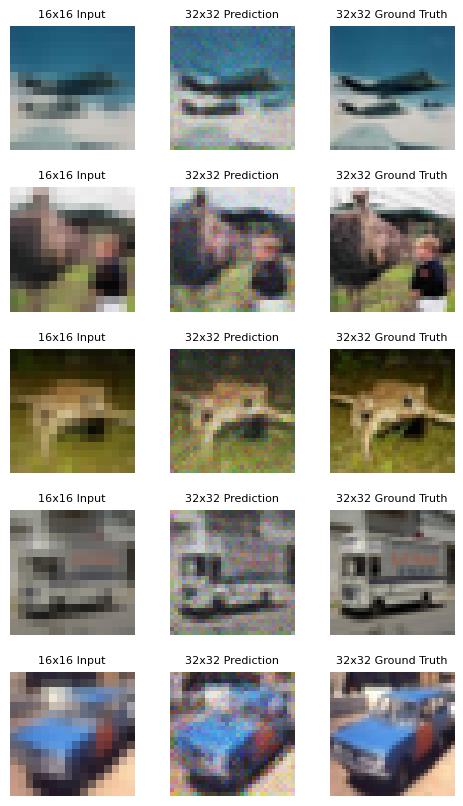

In [9]:
# Generate and Visualize Random Samples
def visualize_samples(model, num_samples=5):
    model.eval()
    with torch.no_grad():
        fig, axs = plt.subplots(num_samples, 3, figsize=(6, num_samples * 2)) 

        random_indices = random.sample(range(len(val_dataset)), num_samples)

        for i, idx in enumerate(random_indices):
            hr_img,lr_img = val_dataset[idx] 
            lr_img, hr_img = lr_img.unsqueeze(0).to(device), hr_img.unsqueeze(0).to(device)

            recon_img, _ = model(hr_img,lr_img)

            lr_img_np = lr_img.cpu().numpy().squeeze() 
            hr_img_np = hr_img.cpu().numpy().squeeze()  
            recon_img_np = recon_img.cpu().numpy().squeeze() 

 
            lr_img_np = np.transpose(lr_img_np, (1, 2, 0))  
            hr_img_np = np.transpose(hr_img_np, (1, 2, 0))  
            recon_img_np = np.transpose(recon_img_np, (1, 2, 0)) 

            axs[i, 0].imshow(lr_img_np)
            axs[i, 0].set_title("16x16 Input", fontsize=8)
            axs[i, 0].axis("off")

            axs[i, 1].imshow(recon_img_np)
            axs[i, 1].set_title("32x32 Prediction", fontsize=8)
            axs[i, 1].axis("off")

            axs[i, 2].imshow(hr_img_np)
            axs[i, 2].set_title("32x32 Ground Truth", fontsize=8)
            axs[i, 2].axis("off")

        plt.subplots_adjust(wspace=0.1, hspace=0.3)  
        plt.show()

visualize_samples(model, num_samples=5)
